In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    wire1 = 1.0 / (1j*2*np.pi*f*wire_c)
    z_electrode_tissue = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    ztot = 1.0 / ((1./z_electrode_tissue)+(1./wire1))

    e = np.sum((np.abs((zr-np.real(ztot))))/(np.abs(zmag))) + \
        np.sum((np.abs((zj-np.abs(np.imag(ztot)))))/(np.abs(zmag)))

    L1 = e / n
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj_nolog.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r.png', dpi=300, bbox_inches='tight')
    
    # residual plots
    plt.figure()
    plt.title(title)
    plt.plot(f, (zj-zj_l1)/zj, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zj-zj_l2)/zj, 's-', label='Log10 L2 norm')
    plt.plot(f, (zj-zj_linf)/zj, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zj-zj_lk)/zj, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'j_resid.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, (zr-zr_l1)/zr, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zr-zr_l2)/zr, 's-', label='Log10 L2 norm')
    plt.plot(f, (zr-zr_linf)/zr, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zr-zr_lk)/zr, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs_pc/' + title + 'r_resid.png', dpi=300, bbox_inches='tight')
    plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
#     solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=25,
#                              limits=bounds, minimize=True)
    solver = pyfde.JADE(obj_function, n_dim=5, n_pop=30,
                        limits=bounds, minimize=True)
    solver.c = np.random.random()
    solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()*2.0
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        print('Polish was better')
    else:
        opts = fit
        results_x = best
        print('Polish did not help')
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=50, n_proc=8):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt





# Attempt sensitivyt study on parasitic capacitance values

In [2]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))


# Parasitic Capacitance Values for Wires
c_values = np.linspace(1e-12, 1000e-12, 10)

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        
        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # remove nans in zr and zj experimental data
        inds = np.where(np.isnan(np.log10(zj)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        inds = np.where(np.isnan(np.log10(zr)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        n = len(f)

        # run log10 optimizations
        for k, wire_c in enumerate(c_values):
            xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_Kait)
            res_l1[k, :5] = x_l1
            res_l1[k, 5] = opt_l1
        break
    break


Optimization runtime 46.0400 seconds
Set of optima: [0.02849813 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849815 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813 0.02849813
 0.02849813 0.02849813]
Best Objective value: 0.028498130712736894
Best Paramters: [3.95986100e-01 6.35681720e-01 1.67826917e+00 1.00000000e+00
 1.00000000e+03] 



Optimization runtime 46.2929 seconds
Set of optima: [0.04318642 0.04318642 0.04318642 0.04318642 0.04318642 0.04318642
 0.04318642 0.04318642 0.04318642 0.04318642 0.04318642 0.04318642
 0.04318642 0.04318642 0.04318642 0.04318642 0.04318642 0.043

# Visualization of the difference from 1pf to 1000 pf

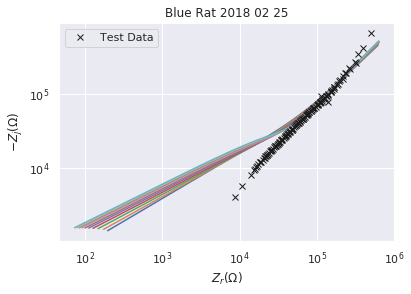

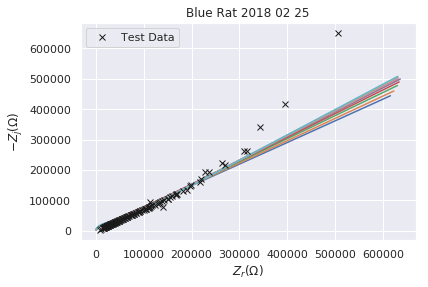

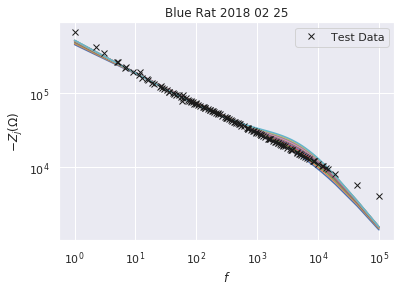

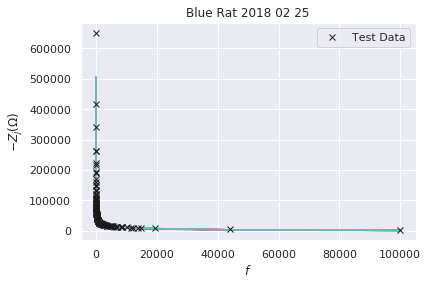

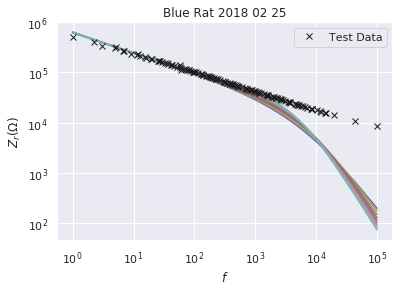

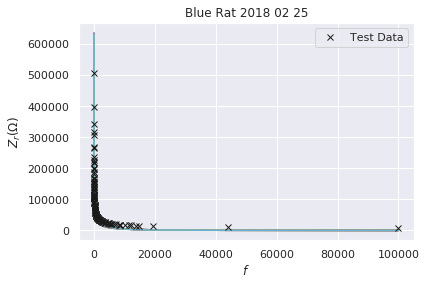

In [3]:
title = 'Blue Rat 2018 02 25'
plt.figure()
plt.title(title)
for i in range(10):
    zr_lk, zj_lk = otto_model_create_data(res_l1[i, :5])
    plt.plot(zr_lk, zj_lk, '-')
plt.plot(zr, zj, 'xk', label='Test Data')

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig('figs/' + title + 'logrj.pdf', dpi=300, bbox_inches='tight')


plt.figure()
plt.title(title)
for i in range(10):
    zr_lk, zj_lk = otto_model_create_data(res_l1[i, :5])
    plt.plot(zr_lk, zj_lk, '-')
plt.plot(zr, zj, 'xk', label='Test Data')

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
# plt.savefig('figs/' + title + 'rj.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
for i in range(10):
    zr_lk, zj_lk = otto_model_create_data(res_l1[i, :5])
    plt.plot(f, zj_lk, '-')
plt.plot(f, zj, 'xk', label='Test Data')

plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig('figs/' + title + 'logj.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
for i in range(10):
    zr_lk, zj_lk = otto_model_create_data(res_l1[i, :5])
    plt.plot(f, zj_lk, '-')
plt.plot(f, zj, 'xk', label='Test Data')

plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
# plt.savefig('figs/' + title + 'j.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
for i in range(10):
    zr_lk, zj_lk = otto_model_create_data(res_l1[i, :5])
    plt.plot(f, zr_lk, '-')
plt.plot(f, zr, 'xk', label='Test Data')
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.savefig('figs/' + title + 'logr.pdf', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
for i in range(10):
    zr_lk, zj_lk = otto_model_create_data(res_l1[i, :5])
    plt.plot(f, zr_lk, '-')
plt.plot(f, zr, 'xk', label='Test Data')
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.legend()
# plt.savefig('figs/' + title + 'r.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
columns = ['alpha CPE phase factor','K CPE magnitude factor', 'ren encapsulation resistance (k ohm)', 'rex extracellular resistance (k ohm)', 'am membrane area in cm**2', 'objective value']
index_rows = ['blue rat 2018_02_25 rep 1', 'blue rat 2018_02_25 rep 2', 'blue rat 2018_02_26 rep 1', 'blue rat 2018_02_26 rep 2', 'blue rat 2018_02_27 rep 1', 'blue rat 2018_02_27 rep 2',
             'blue rat 2018_03_03 rep 1', 'blue rat 2018_03_03 rep 2', 'blue rat 2018_03_10 rep 1', 'blue rat 2018_03_10 rep 2']
index_rows = c_values
pd_l1 = pd.DataFrame(res_l1, index=index_rows, columns=columns)


# L1 Norm

In [5]:
pd_l1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
1.000000e-12,0.395986,0.635682,1.678269,1.000000,1000.0,0.028498
1.120000e-10,0.404968,0.615489,5.667111,1.000000,1000.0,0.043186
2.230000e-10,0.415010,0.593737,9.823972,1.000000,1000.0,0.062157
3.340000e-10,0.422591,0.580177,13.531926,1.000000,1000.0,0.083197
4.450000e-10,0.429040,0.569638,16.900002,1.000000,1000.0,0.106600
5.560000e-10,0.431985,0.571397,19.959044,1.000000,1000.0,0.129215
6.670000e-10,0.435205,0.568476,22.620657,1.000005,1000.0,0.150783
7.780000e-10,0.439213,0.563902,25.457232,1.000019,1000.0,0.170618
8.890000e-10,0.441424,0.562649,27.915918,1.000235,1000.0,0.188416
1.000000e-09,0.444023,0.560473,30.285606,1.000000,1000.0,0.204862


In [6]:
pd_l1.describe()

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000
mean,0.425945,0.582162,17.383974,1.000026,1.000000e+03,0.116753
std,0.016134,0.025293,9.619341,0.000074,4.255383e-08,0.061936
min,0.395986,0.560473,1.678269,1.000000,1.000000e+03,0.028498
25%,0.416906,0.565045,10.750960,1.000000,1.000000e+03,0.067417
50%,0.430513,0.570517,18.429523,1.000000,1.000000e+03,0.117908
75%,0.438211,0.590347,24.748088,1.000004,1.000000e+03,0.165659
max,0.444023,0.635682,30.285606,1.000235,1.000000e+03,0.204862
